This notebook calculates the direct damages to rail assets including climate change

In [1]:
# Imports
import configparser
from pathlib import Path
import pathlib
from direct_damages import damagescanner_rail_track as ds
import pandas as pd
import geopandas as gpd
import datetime
from ci_adapt_utilities import *
import pickle

In [2]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

In [3]:
# Read vulnerability and maximum damage data from Nirandjan, S., et al. (2024)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

Found matching infrastructure curves for: rail


In [4]:
# Read hazard data (Rauthe M, et al. (2020): Climate impact analysis of the federal transport system in the context of floods: Final report of the key topic flood risks (SP-103) in topic area 1 of the BMVI expert network. 136 pages. DOI: 10.5675/ExpNRM2020.2020.04)
hazard_data_list = ds.read_hazard_data(data_path, hazard_type, country=country_name, subfolders=hazard_data_subfolders)
print(f'Found {len(hazard_data_list)} hazard maps.')

Found 12 hazard maps.


In [5]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = gpd.read_file(assets_path)
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})

# #TODO: add reset index and test 
# # Drop passenger lines and light rails
# assets = assets.loc[~(assets['railway:traffic_mode'] == 'passenger')]
# assets = assets.loc[~(assets['asset'] == 'light_rail')]

# # Drop bridges and tunnels
# assets = assets.loc[~(assets['bridge'].isin(['yes']))]
# assets = assets.loc[~(assets['tunnel'].isin(['yes']))]

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

3530 assets loaded.


In [6]:
# Calculate direct damage by asset (Koks. E.E. (2022). DamageScanner: Python tool for natural hazard damage assessments. Zenodo. http://doi.org/10.5281/zenodo.2551015)
# currently data with 3 baseline return periods: H=RP10, M=RP100, L=RP200
# TODO: for DEXX_RP, return period should be input or taken from dictionary/file names
# TODO: verify cost of damage and adaptation regarding double rail or single rail, divide /2 if double rail? 
collect_output={}
for i, single_footprint in enumerate(hazard_data_list):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Reading hazard map {i+1} of {len(hazard_data_list)}: {hazard_name}')

    try:
        collect_output[hazard_name] = process_hazard_data(single_footprint, hazard_type, assets, interim_data_path, infra_curves, max_damage_tables, curve_types, infra_type, type_dict, geom_dict)
    except Exception as e:
        print(f'Error occurred in {hazard_name}: {str(e)}')
        continue

# save the data to pickle files
collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
if len(collect_output)>0:
    with open(collect_output_path, 'wb') as f:
        pickle.dump(collect_output, f)
else: print('No output collected')

2024-05-02 09:10:35 - Reading hazard map 1 of 12: flood_DERP_RW_H_4326_2080411370
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080411370.geojson
2024-05-02 09:10:38 - Coarse overlay of hazard map with assets...


100%|██████████| 19/19 [00:14<00:00,  1.30it/s]


2024-05-02 09:11:45 - Reading hazard map 2 of 12: flood_DERP_RW_H_4326_2080416200
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080416200.geojson
2024-05-02 09:11:55 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


2024-05-02 09:13:34 - Reading hazard map 3 of 12: flood_DERP_RW_H_4326_2080416210
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080416210.geojson
2024-05-02 09:13:42 - Coarse overlay of hazard map with assets...


100%|██████████| 24/24 [00:57<00:00,  2.41s/it]


2024-05-02 09:17:18 - Reading hazard map 4 of 12: flood_DERP_RW_H_4326_2080418880
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080418880.geojson
2024-05-02 09:17:23 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


2024-05-02 09:17:40 - Reading hazard map 5 of 12: flood_DERP_RW_L_4326_2080411370
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_L_4326_2080411370.geojson
2024-05-02 09:17:43 - Coarse overlay of hazard map with assets...


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


2024-05-02 09:20:16 - Reading hazard map 6 of 12: flood_DERP_RW_L_4326_2080416200
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_L_4326_2080416200.geojson
2024-05-02 09:20:30 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


2024-05-02 09:23:11 - Reading hazard map 7 of 12: flood_DERP_RW_L_4326_2080416210
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_L_4326_2080416210.geojson
2024-05-02 09:23:19 - Coarse overlay of hazard map with assets...


100%|██████████| 155/155 [05:35<00:00,  2.16s/it]


2024-05-02 09:30:35 - Reading hazard map 8 of 12: flood_DERP_RW_L_4326_2080418880
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_L_4326_2080418880.geojson
2024-05-02 09:30:42 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


2024-05-02 09:31:44 - Reading hazard map 9 of 12: flood_DERP_RW_M_4326_2080411370
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_M_4326_2080411370.geojson
2024-05-02 09:31:48 - Coarse overlay of hazard map with assets...


100%|██████████| 43/43 [01:00<00:00,  1.40s/it]


2024-05-02 09:33:49 - Reading hazard map 10 of 12: flood_DERP_RW_M_4326_2080416200
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_M_4326_2080416200.geojson
2024-05-02 09:34:01 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


2024-05-02 09:35:56 - Reading hazard map 11 of 12: flood_DERP_RW_M_4326_2080416210
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_M_4326_2080416210.geojson
2024-05-02 09:36:04 - Coarse overlay of hazard map with assets...


100%|██████████| 94/94 [03:09<00:00,  2.02s/it]


2024-05-02 09:45:25 - Reading hazard map 12 of 12: flood_DERP_RW_M_4326_2080418880
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_M_4326_2080418880.geojson
2024-05-02 09:45:31 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [00:00<00:00, 12.63it/s]


In [7]:
# Save the data to csv files
pd.DataFrame.from_dict(collect_output).to_csv(interim_data_path / 'sample_collected_run.csv')

Baseline expected annual damages: 5,080,960.58 to 12,431,021.26 EUR
Expected annual damages without adaptation by year 100: 22,568,969.47 to 53,224,947.94 EUR


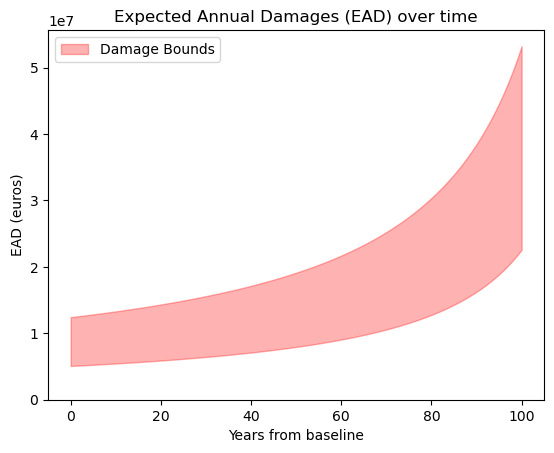

In [8]:
# Calculate the expected annual damages (EAD)
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

# Initialize a new dictionary to hold the aggregated values
aggregated_output = {'_H_': [0, 0], '_M_': [0, 0], '_L_': [0, 0]}

# Iterate over the items in the summed_output dictionary and group into return periods
for hazard_map, (lower_bound, upper_bound) in summed_output.items():
    # determine the category of the hazard map
    if '_H_' in hazard_map: 
        category = '_H_'
    elif '_M_' in hazard_map: 
        category = '_M_'
    else: # '_L_' in hazard_map
        category = '_L_' 
        
    # Add the lower and upper bounds to the appropriate category
    aggregated_output[category][0] += lower_bound
    aggregated_output[category][1] += upper_bound

# Create the DataFrame from the new dictionary
aggregated_df = pd.DataFrame.from_dict(aggregated_output, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

"""
Return period definitions:
_H_=10-25y 
_M_=100y
_L_=200y (or more, check report)
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}
increase_factor = {
    '_H_': (1.2+9.0)/2,
    '_M_': (1.2+9.0)/2,
    '_L_': (1.2+9.0)/2 #average of the range (1.2 to 9.0) based on change since 1900
}

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

# Define dictionary to relate return periods to regions, in this case Rheinland Palatinate is used
return_period_dict = {}
return_period_dict['DERP'] = return_periods #TODO: make generic for other regions

# Add the return period column to aggregated_df and sort by return period
aggregated_df['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df.index]
aggregated_df = aggregated_df.sort_values('Return Period', ascending=True)

# Calculate the probability of each return period 
aggregated_df['Probability'] = [[1 / x for x in i] for i in aggregated_df['Return Period']]
probabilities = aggregated_df['Probability']
dmgs = []

# Calculate the expected annual damages for each time step using trapezoidal rule for integration
for ts in range(len(probabilities.iloc[0])):    
    dmgs_l = []
    dmgs_u = []

    for rp in range(len(probabilities)-1):
        d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
        trap_damage_l = 0.5 * (aggregated_df['Total Damage Lower Bound'].iloc[rp] + aggregated_df['Total Damage Lower Bound'].iloc[rp + 1])
        trap_damage_u = 0.5 * (aggregated_df['Total Damage Upper Bound'].iloc[rp] + aggregated_df['Total Damage Upper Bound'].iloc[rp + 1])
        dmgs_l.append(d_rp * trap_damage_l)
        dmgs_u.append(d_rp * trap_damage_u)
    
    # Add the portion of damages corresponding to the tails of the distribution
    # Assumption - considers the damage for return periods higher than the highest return period the same as that of the highest return period
    d0_rp = probabilities.iloc[-1][ts]
    damage_l0 = max(aggregated_df['Total Damage Lower Bound'])
    damage_u0 = max(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d0_rp * damage_l0)
    dmgs_u.append(d0_rp * damage_u0)

    # Assumption - considers that no assets are damaged at a return period of 4 years or lower
    d_end_rp = (1/4)-probabilities.iloc[0][ts]
    damage_l_end = 0.5 * min(aggregated_df['Total Damage Lower Bound'])
    damage_u_end = 0.5 * min(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d_end_rp * damage_l_end)
    dmgs_u.append(d_end_rp * damage_u_end)

    dmgs.append((sum(dmgs_l), sum(dmgs_u)))

ead_by_ts = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

print(f'Baseline expected annual damages: {dmgs[0][0]:,.2f} to {dmgs[0][1]:,.2f} EUR')
print(f'Expected annual damages without adaptation by year {num_years}: {dmgs[-1][0]:,.2f} to {dmgs[-1][1]:,.2f} EUR')

ead_by_ts_plot(ead_by_ts)